# TAP Queries
An example which shows how to make queries to the TAP service of `vo.astro.rug.nl`.

In [1]:
from astroquery.utils.tap.core import Tap

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time

from matplotlib.pyplot import figure, show
import numpy as np

## Connect to the service

In [2]:
vo_url = "http://vo.astro.rug.nl/tap"
vo = Tap(url=vo_url, verbose=True)

Created TAP+ (v1.2.1) - Connection:
	Host: vo.astro.rug.nl
	Use HTTPS: False
	Port: 80
	SSL Port: 443


## Query the service
To query the service and immediately get the result, use the `launch_job` method and give it a query (ADQL). An example query is given below.

The result of the query is a job, from which the result can be retrieved (as an astropy Table) using the `get_results()` method.

In [3]:
query = """
SELECT TOP 10 filename, ra, dec, date_obs
FROM observations.raw
WHERE ra IS NOT NULL
ORDER BY date_obs
"""

job = vo.launch_job(query)
table = job.get_results()

table.info()  # some simple information on the resulting table

<Table length=10>
  name    dtype  unit                                                       description                                                      
-------- ------- ---- -----------------------------------------------------------------------------------------------------------------------
filename  object                                                        Absolute path to the corresponding fits file on the Vega data server.
      ra float64  deg                         Right Ascention (degrees) coordinate of where the telescope is pointed. Derived from 'OBJCTRA'.
     dec float64  deg                            Declination (degrees) coordinate of where the telescope is pointed. Derived from 'OBJCTDEC'.
date_obs  object      Datetime string of the moment the observation was taken (in UTC). See 'obs_jd' column for the same time in Julian Days.


To see what is actually in the table, provided you are in a notebook, just state the table. The first row gives the column names, the second units and the third the python types. The other rows are the resulting data.

In [4]:
table

filename,ra,dec,date_obs
,deg,deg,
object,float64,float64,object
/net/vega/data/users/observatory/images/090309/STL-6303E/i/090309_Li_021.fits,218.09814999999998,26.673555555555556,2009-03-10T00:43:14.203
/net/dataserver3/data/users/noelstorr/blaauwastrom/090309/astrom_090309_Li_021.fits,218.105519551,26.7344644832,2009-03-10T00:43:14.203
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_001.fits,113.850723895,65.6476491812,2009-03-17T19:42:34.906
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_002.fits,113.850857426,65.6476134898,2009-03-17T19:46:17.234
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_003.fits,172.282323816,28.9624338909,2009-03-17T20:00:40.234
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_004.fits,172.282282288,28.9624505782,2009-03-17T20:02:01.656
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_005.fits,133.248155591,-0.720509034562,2009-03-17T20:08:29.046
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_006.fits,133.248187443,-0.720442761718,2009-03-17T20:09:40.921


As the result is, conveniently, an astropy Table we can easily perform some operations on it. For example, get a list of coordinates using the SkyCoord class. You can explicitly give the columns to the skycoord object alongside a unit (degrees in this case), or just guess using the `guess_from_table` method.
As both give the same result, the latter is more convenient.

In [5]:
from matplotlib.pyplot import figure, show
import numpy as np

c = SkyCoord(table['ra'], table['dec'], unit='deg')  # explicit (give unit & columns)
c = SkyCoord.guess_from_table(table)                 # guess

c.get_constellation() # use any of the SkyCoord methods !

array(['Boötes', 'Boötes', 'Camelopardalis', 'Camelopardalis',
       'Ursa Major', 'Ursa Major', 'Hydra', 'Hydra', 'Cancer', 'Cancer'],
      dtype='<U19')

## Example: Get a Histogram of Observations per day Starting from 2019

In [6]:
# Get the JD version of Jan 1st of 2019
since_date = Time('2019-01-01T12:00:00.000').jd

# Prepare query
query = """
SELECT TOP 20000 FLOOR(obs_jd) as obs_jd
FROM observations.raw
WHERE imagetyp = 'Light Frame' AND obs_jd >= {}
""".format(since_date)

# Launch the job and get the resulting table
job = vo.launch_job(query)
table = job.get_results()

In [7]:
days = table['obs_jd'].astype(int) - int(since_date)  # offset by the starting date for nicer display

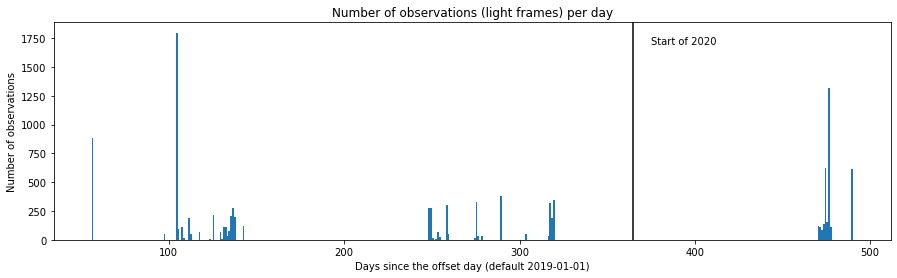

In [8]:
# Prepare the figure
fig = figure(figsize=(15, 4))
ax = fig.add_subplot(1, 1, 1)

# Plot the histogram
n, bins, patches = ax.hist(days, bins=days.max() - days.min())

# Add the 2020 line
t = Time('2020-01-01T12:00:00.000').jd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2020")

# Add some labels and a title
ax.set_ylabel('Number of observations')
ax.set_xlabel('Days since the offset day (default 2019-01-01)')
ax.set_title("Number of observations (light frames) per day")
show()

## Example: Plot the Coordinates of all Observations

In [9]:
query = """
SELECT TOP 20000 ra, dec
FROM observations.raw
WHERE ra IS NOT NULL 
  AND dec IS NOT NULL
  AND imagetyp = 'Light Frame'
  AND filename NOT LIKE '%/g/%'
"""

job = vo.launch_job(query)

In [10]:
table = job.get_results()
table.info()

<Table length=9058>
name  dtype  unit                                           description                                          
---- ------- ---- -----------------------------------------------------------------------------------------------
  ra float64  deg Right Ascention (degrees) coordinate of where the telescope is pointed. Derived from 'OBJCTRA'.
 dec float64  deg    Declination (degrees) coordinate of where the telescope is pointed. Derived from 'OBJCTDEC'.


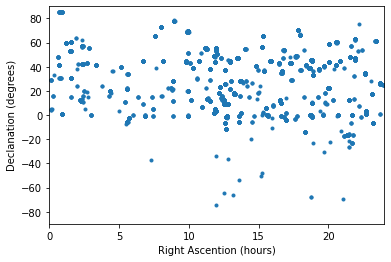

In [11]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

ra = table['ra']
dec = table['dec']
ax.scatter(ra / (360/24), dec, marker='.')

ax.set_ylim(-90, 90)
ax.set_xlim(0, 24)

ax.set_xlabel('Right Ascention (hours)')
ax.set_ylabel('Declanation (degrees)')

show()

We also create a second plot which perhaps is less scientific, but gives a better view on the density of the observations. The rounded effect is done by interpolating (otherwise there would not be a lot visible).

In [12]:
hist2d, xedge, yedge = np.histogram2d(ra, dec, bins=[20, 10], range=[[0, 360], [-90, 90]])
hist2d += 1
hist2d = np.log(hist2d)

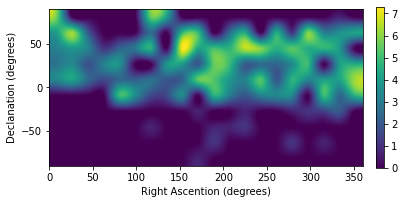

In [13]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(hist2d.T, origin='lower', interpolation='spline16', extent=[0, 360, -90, 90])

ax.set_xlabel('Right Ascention (degrees)')
ax.set_ylabel('Declanation (degrees)')

fig.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
show()

## Example: Retrieving all Filenames Satisfying a Certain Query

In [14]:
object_name = "Jupiter"

query = """
SELECT filename, object, ra, dec, date_obs
FROM observations.raw
WHERE object = '{}'
ORDER BY date_obs
""".format(object_name)

job = vo.launch_job(query)
table = job.get_results()

In [15]:
# Note that we need to use .decode() !
filenames = [fn.decode() for fn in table['filename']] 

# Print part of the resulting list on separate lines
print('\n'.join(filenames[:6]))
print('...')
print('\n'.join(filenames[-6:]))

/net/vega/data/users/observatory/images/080925/STL-6303E/i/Jupiter2.fits
/net/vega/data/users/observatory/images/080925/STL-6303E/i/Jupiter3.fits
/net/vega/data/users/observatory/images/080926/STL-6303E/i/Jupiter0.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterR0,2s1.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterV0,2s2.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterV10s3.fits
...
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000038.Jupiter.FIT
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000039.Jupiter.FIT
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000040.Jupiter.FIT
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000041.Jupiter.FIT
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000042.Jupiter.FIT
/net/vega/data/users/observatory/images/111023/STL-6303E/i/111023_Li_.00000043.Jupiter.FI

## Example: Selecting Observations Closest to a Given Date

In [16]:
# night of the 17th of April 2020
ref_date = Time("2020-04-18T01:25:53.895").jd  

query = """
SELECT TOP 100 filename, date_obs, ABS(obs_jd - {}) AS difference
FROM observations.raw
ORDER BY difference
""".format(ref_date)

job = vo.launch_job(query)
table = job.get_results()

Now more specific (an example from my own Observational Astronomy project).

We had the case where we needed 3x3 binned Flat Field images, but only 1x1 binned were taken on that night. So, we wanted to find the next best thing, which are the most recent 3x3 flats relative to our observation night.

In addition, we solve the issue of the absolute difference, which can lead to a mix of results from before and after the date.

In [17]:
query = """
SELECT TOP 10 filename, date_obs, filter,
              ABS(obs_jd - {0}) AS abs_difference,
              obs_jd - {0} AS difference
FROM observations.raw
WHERE imagetyp = 'Flat Field' AND xbinning = 3 AND ybinning = 3
ORDER BY abs_difference
""".format(ref_date)

job = vo.launch_job(query)
table = job.get_results()

In [18]:
selector = table['difference'] < 0

print('Taken before date:')
print(table[selector]['filename'])

print()
print()

print('Taken after date:')
print(table[~selector]['filename'])

Taken before date:
filename
--------


Taken after date:
                                                   filename                                                   
--------------------------------------------------------------------------------------------------------------
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000030.13h13m22.7s_27d58m22sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000031.13h13m29.8s_27d58m47sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000032.13h13m36.8s_27d59m13sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000033.13h13m44.8s_27d59m38sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000034.13h13m50.8s_28d00m04sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000035.13h13m59.8s_28d00m30sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303

## Example: Incorrect Plate Scale Overview

In this example we investigate all the plate scale values, which should all be constant for a given binning. We see that there will be some incorrect plate scales and see to which coordinates they correspond.

In [114]:
query = """
SELECT top 200000 plate_scale, odds, xbinning, ra, dec
from observations.raw
where plate_scale is not NULL
"""
job = vo.launch_job(query)
table = job.get_results()

In [40]:
# Get medians of each xbinning
medians = [np.median(np.array(table['plate_scale'][table['xbinning']==i])) for i in range(1, 4)]

# If the medians are correct, NxN binned scaled should be N*(1x1 scale)
print('median | n*median_0')
print('-------|-----------')
for n, median in enumerate(medians, 1):
    print("{:.4f} | {:.4f}".format(median, n*medians[0]))

median | n*median_0
-------|-----------
0.5662 | 0.5662
1.1325 | 1.1324
1.6979 | 1.6985


Here we isolate all the datapoints which are incorrect and give some statistics about them. We also remember the ra and dec coordinated of these incorrect plate scales for later use.

In [102]:
print('bin | err | err fraction')
print('----|-----|-------------')
all_off_scales = []
all_off_ra = []
all_off_dec = []

for i in range(1, 4):
    arr = np.array(table['plate_scale'][table['xbinning']==i])
    ra = np.array(table['ra'][table['xbinning']==i])
    dec = np.array(table['dec'][table['xbinning']==i])
    
    med = np.median(arr)
    bool_idx = np.abs(arr - med) > 0.01
    
    off_scales = arr[bool_idx]
    off_ra = ra[bool_idx]
    off_dec = dec[bool_idx]
    
    all_off_scales.append(off_scales)
    all_off_ra.extend(off_ra)
    all_off_dec.extend(off_dec)
    
    print(" {}  |  {:2d} | {:.5f}".format(i, off_scales.size, off_scales.size/arr.size))

all_off_ra = np.array(all_off_ra)
all_off_dec = np.array(all_off_dec)

bin | err | err fraction
----|-----|-------------
 1  |  32 | 0.00760
 2  |   2 | 0.00287
 3  |  20 | 0.01189


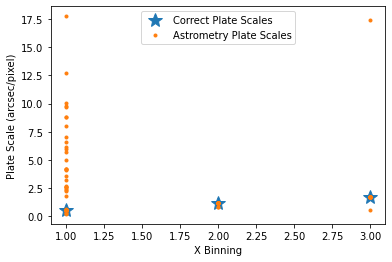

In [53]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot([1, 2, 3], medians, '*', markersize=14, label='Correct Plate Scales')
ax.plot(table['xbinning'], table['plate_scale'], '.', label='Astrometry Plate Scales')

ax.set_ylabel("Plate Scale (arcsec/pixel)")
ax.set_xlabel("X Binning")
ax.legend()
show()

We plot the odds against the plate scales to see if there is a relation between the two. The figure seems to confirm that a low odd, 

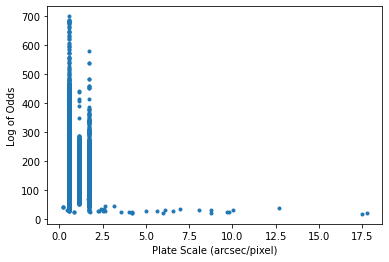

In [113]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(table['plate_scale'], np.log(table['odds']), '.')

ax.set_xlabel("Plate Scale (arcsec/pixel)")
ax.set_ylabel("Log of Odds")
show()

We now plot all the coordinates which have been observed (see previous example), and plot a red cross over those which have incorrect plate scales. As can be seen, all impossible observations (dec below -20 degrees) are crossed out.

In [122]:
query = """
SELECT top 200000 filename, ra, dec
from observations.raw
where ra is not NULL and dec is not NULL
  AND imagetyp = 'Light Frame'
  AND filename NOT LIKE '%/g/%'
"""
job = vo.launch_job(query)
new_table = job.get_results()

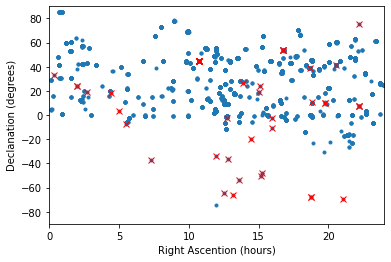

In [118]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

scale = 24/360
ax.scatter(new_table['ra'] * scale, new_table['dec'], marker='.')

# Plot all coordinates with incorrect plate scales
ax.plot(all_off_ra * scale, all_off_dec, 'x', color='r')

ax.set_ylim(-90, 90)
ax.set_xlim(0, 24)

ax.set_xlabel('Right Ascention (hours)')
ax.set_ylabel('Declanation (degrees)')

show()

In [124]:
idx = new_table['dec'].argmin()
new_table['filename'][idx]

b'/net/vega/data/users/observatory/images/090922/STL-6303E/i/090920_Li.00000107.11h56m54.7s_74d03m45sS.FIT'